In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy import interpolate

In [109]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("SEOB_4D_MM_data.txt",names = columns)
print(datatab)
# #datatab.iloc[229]
data1 = datatab.iloc[0:230]
print(data1)

       x         y    z     w      data     error
0    0.1 -1.439897  0.0  0.25 -2.831628  0.815517
1    0.1 -1.308997  0.5  0.25 -3.006489  0.926090
2    0.1 -1.178097  1.0  0.25 -2.354835  0.699513
3    0.1 -1.047198  1.0  0.25 -2.974002  0.712574
4    0.1 -0.916298  1.0  0.25 -2.401510  0.699986
..   ...       ...  ...   ...       ...       ...
995  0.7  1.570796 -1.0  1.00 -2.287634  0.687055
996  0.8  1.570796 -1.0  1.00 -2.164392  0.692650
997  0.9  1.570796 -1.0  1.00 -2.152368  0.693543
998  1.0 -1.439897 -1.0  1.00 -2.579505  1.226236
999  1.0  1.439897 -1.0  1.00 -2.114922  0.841748

[1000 rows x 6 columns]
       x         y    z     w      data     error
0    0.1 -1.439897  0.0  0.25 -2.831628  0.815517
1    0.1 -1.308997  0.5  0.25 -3.006489  0.926090
2    0.1 -1.178097  1.0  0.25 -2.354835  0.699513
3    0.1 -1.047198  1.0  0.25 -2.974002  0.712574
4    0.1 -0.916298  1.0  0.25 -2.401510  0.699986
..   ...       ...  ...   ...       ...       ...
225  1.0  1.047198 -1.0  

In [141]:
x = data1['x'].values
y = data1['y'].values
z = data1['z'].values
w = data1['w'].values
data = data1['data'].values
error = data1['error'].values


print(x)

## FIXME  need to mean revert y !!!

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.7 0.7 0.7 0.7 0.7 0.7
 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]


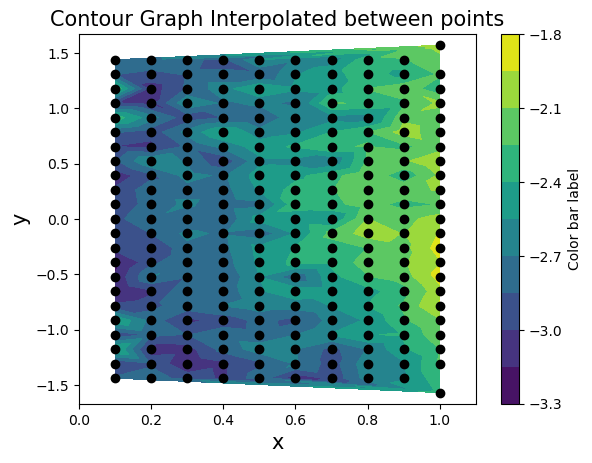

In [161]:
f, ax = plt.subplots()
contour = ax.tricontourf(x, y, data, levels=10, cmap="viridis")  
## FIXME research tricontourf and how it interpolates between points
ax.plot(x, y, 'ko')  

ax.set_xlim([x.min() - .1, x.max() + .1])
ax.set_ylim([y.min() - .1, y.max() + .1])

cbar = plt.colorbar(contour, ax=ax, extend='both')  
cbar.set_label("Color bar label")  
plt.xlabel('x', size = 15)
plt.ylabel('y', size = 15)
plt.title('Contour Graph Interpolated between points', size = 15)
plt.show()

In [147]:
X = np.column_stack((x.reshape(-1), y.reshape(-1),z.reshape(-1)))
Trudata = data.reshape(-1,1)

guess_l = (1., 1.,1.)  
bounds_l = ((1e-20,3.),) * 3  
guess_n = 1.  
bounds_n = (1e-20, 3.) 
kernel = (RBF(length_scale=guess_l, length_scale_bounds=bounds_l)+ WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n))

X_train, X_test, Y_train, Y_test = train_test_split(X, Trudata, train_size = 0.9, random_state = 1)

gpr = GaussianProcessRegressor(kernel,normalize_y=True ,n_restarts_optimizer=10)
gpr.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1, 1]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10, normalize_y=True)

In [149]:
print(gpr.kernel_)

RBF(length_scale=[0.511, 1.2, 2.73]) + WhiteKernel(noise_level=0.183)


In [151]:
Datafit, Datastd = gpr.predict(X, return_std=True)
datastd = Datastd.reshape(x.shape)
datafit = Datafit.reshape(x.shape)
print(datafit.shape)

(230,)


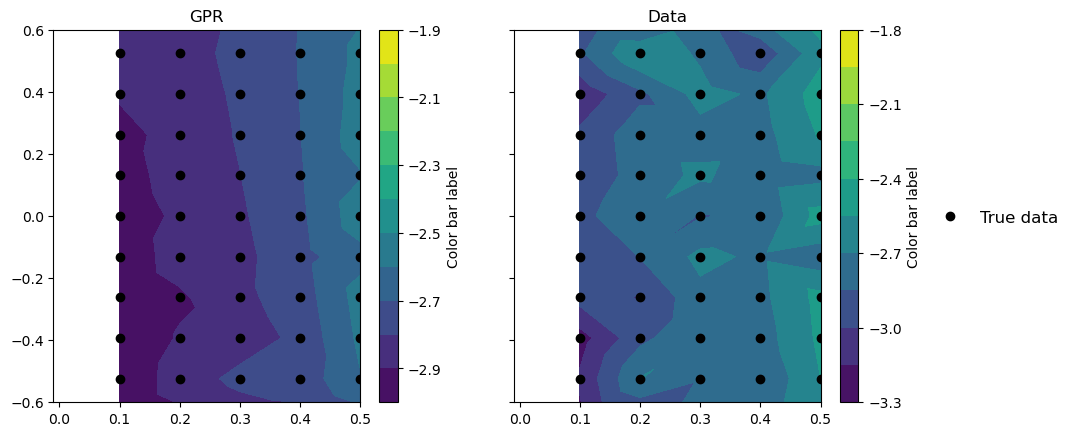

In [153]:
fig, ax = plt.subplots(1,2,sharex = True,sharey = True, figsize = (10,5))
ax[0].set_xlim((-0.01,0.5))
ax[0].set_ylim((-0.6,.6))
ax[0].set_title('GPR')
ax[0].plot(x,y,'ko',label = 'True data')  # Training samples
#ax[0].plot(*X_test.T, marker='o', color='orange', linestyle='none', label='Testing data')
contour = ax[0].tricontourf(x, y,datafit,levels = 10, cmap="viridis")  # mean
cbar = plt.colorbar(contour, ax=ax[0], extend='both')  # Extend adds color to extreme values
cbar.set_label("Color bar label")  # Label for color bar
ax[1].set_xlim((-0.01,0.5))
ax[1].set_ylim((-0.6,.6))
ax[1].set_title('Data')
ax[1].plot(x, y, 'ko')  
contour1 = ax[1].tricontourf(x, y, data, levels=10, cmap="viridis")  
cbar = plt.colorbar(contour1, ax=ax[1], extend='both')  # Extend adds color to extreme values
cbar.set_label("Color bar label")  # Label for color bar
plt.tight_layout(pad=3)
fig.legend(loc='center left', bbox_to_anchor=(.95, 0.5), frameon=False,fontsize=12 )